Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4297 entries, 0 to 4296
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SettlementValue           4297 non-null   float64
 1   AccidentType              4226 non-null   object 
 2   InjuryPrognosis           4297 non-null   int64  
 3   SpecialHealthExpenses     4297 non-null   float64
 4   SpecialReduction          4297 non-null   float64
 5   SpecialOverage            4297 non-null   float64
 6   GeneralRest               4297 non-null   float64
 7   SpecialAdditionalInjury   4297 non-null   float64
 8   SpecialEarningsLoss       4297 non-null   float64
 9   SpecialUsageLoss          4297 non-null   float64
 10  SpecialMedications        4297 non-null   float64
 11  SpecialAssetDamage        4297 non-null   float64
 12  SpecialRehabilitation     4297 non-null   float64
 13  SpecialFixes              4297 non-null   flo

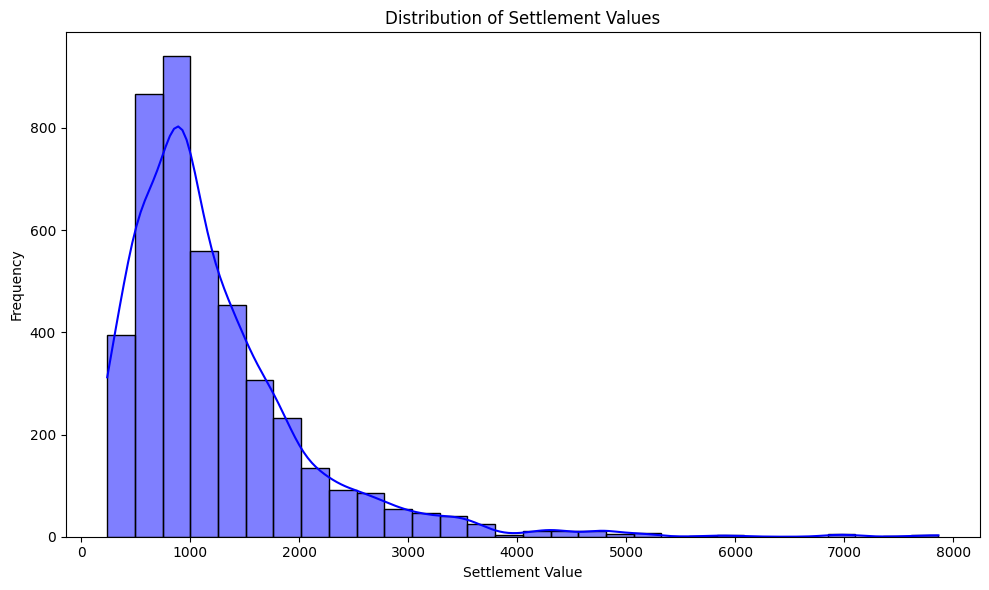

In [10]:
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed claim data
data_path = 'ProcessedClaimData.csv'  # Update this path if necessary
claim_data = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset Overview:")
print(claim_data.info())
print("\nFirst 5 rows of the dataset:")
print(claim_data.head())

# Check for missing values
missing_values = claim_data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Basic statistics of numerical columns
print("\nBasic statistics of numerical columns:")
print(claim_data.describe())

# Visualize the distribution of the target variable
target_col = 'SettlementValue'
plt.figure(figsize=(10, 6))
sns.histplot(claim_data[target_col], kde=True, bins=30, color='blue')
plt.title('Distribution of Settlement Values')
plt.xlabel('Settlement Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Original Settlement Value statistics:
count    4297.000000
mean     1218.505187
std       858.286445
min       240.000000
25%       670.000000
50%       989.000000
75%      1515.000000
max      7862.900000
Name: SettlementValue, dtype: float64

Log-transformed Settlement Value statistics:
count    4297.000000
mean        6.900062
std         0.649392
min         5.484797
25%         6.508769
50%         6.897705
75%         7.323831
max         8.970038
Name: LogSettlementValue, dtype: float64


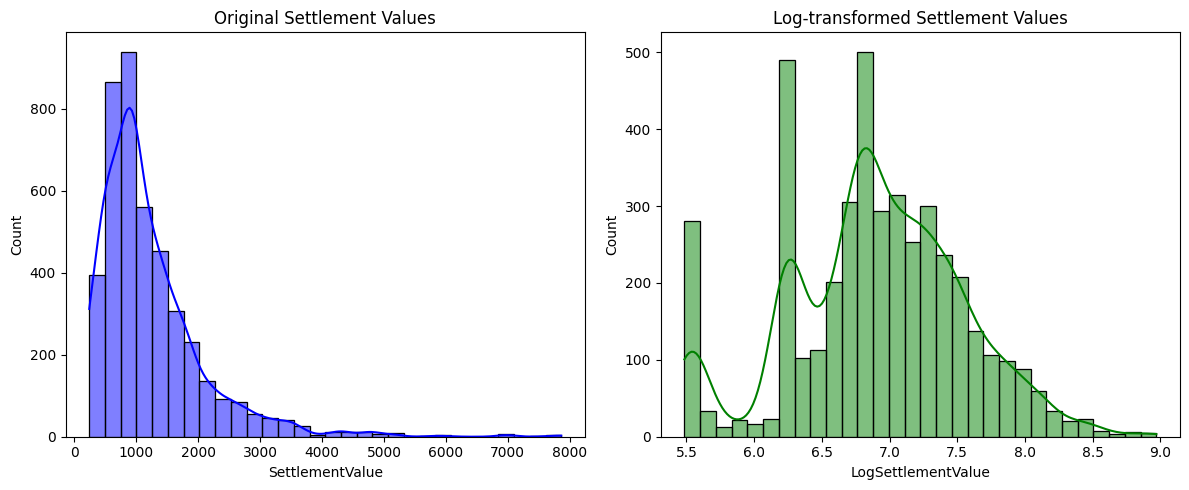

In [11]:
# Add this after loading the data
import numpy as np

# Apply log transformation to the target variable
claim_data['LogSettlementValue'] = np.log1p(claim_data[target_col])
print("Original Settlement Value statistics:")
print(claim_data[target_col].describe())
print("\nLog-transformed Settlement Value statistics:")
print(claim_data['LogSettlementValue'].describe())

# Update target column to use log-transformed values
original_target_col = target_col
target_col = 'LogSettlementValue'

# Visualize the transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(claim_data[original_target_col], kde=True, bins=30, color='blue')
plt.title('Original Settlement Values')
plt.subplot(1, 2, 2)
sns.histplot(claim_data[target_col], kde=True, bins=30, color='green')
plt.title('Log-transformed Settlement Values')
plt.tight_layout()
plt.show()

# Prepare Data for PyTorch
Convert the pandas dataframe to PyTorch tensors. Handle categorical variables by encoding them appropriately. Split the data into training, validation, and test sets.

In [12]:
# Encode categorical variables and prepare data for PyTorch
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import DataLoader, TensorDataset

# Identify categorical and numerical columns
categorical_cols = claim_data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = claim_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remove the target column from the feature list
if target_col in numerical_cols:
    numerical_cols.remove(target_col)

# One-hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Apply transformations
X = preprocessor.fit_transform(claim_data.drop(columns=[target_col]))
y = claim_data[target_col].values

# Standardize numerical features
scaler = StandardScaler()
X[:, :len(numerical_cols)] = scaler.fit_transform(X[:, :len(numerical_cols)])

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoader objects for PyTorch
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(val_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")

Training set size: 3007 samples
Validation set size: 645 samples
Test set size: 645 samples


# Build Neural Network Model
Implement a simple PyTorch neural network model for regression. Design the architecture with appropriate input size, hidden layers, and output layer. Implement optimization for Apple Silicon using MPS backend if available.

Using device: mps
Epoch 1/50, Train Loss: 17.5409, Val Loss: 0.5628
Epoch 2/50, Train Loss: 0.4561, Val Loss: 0.2449
Epoch 3/50, Train Loss: 0.2304, Val Loss: 0.1838
Epoch 4/50, Train Loss: 0.1514, Val Loss: 0.1295
Epoch 5/50, Train Loss: 0.1076, Val Loss: 0.1065
Epoch 6/50, Train Loss: 0.0799, Val Loss: 0.0900
Epoch 7/50, Train Loss: 0.0621, Val Loss: 0.0719
Epoch 8/50, Train Loss: 0.0488, Val Loss: 0.0704
Epoch 9/50, Train Loss: 0.0392, Val Loss: 0.0520
Epoch 10/50, Train Loss: 0.0309, Val Loss: 0.0475
Epoch 11/50, Train Loss: 0.0245, Val Loss: 0.0373
Epoch 12/50, Train Loss: 0.0213, Val Loss: 0.0403
Epoch 13/50, Train Loss: 0.0206, Val Loss: 0.0333
Epoch 14/50, Train Loss: 0.0189, Val Loss: 0.0365
Epoch 15/50, Train Loss: 0.0178, Val Loss: 0.0323
Epoch 16/50, Train Loss: 0.0178, Val Loss: 0.0364
Epoch 17/50, Train Loss: 0.0161, Val Loss: 0.0295
Epoch 18/50, Train Loss: 0.0146, Val Loss: 0.0277
Epoch 19/50, Train Loss: 0.0141, Val Loss: 0.0334
Epoch 20/50, Train Loss: 0.0156, Val Los

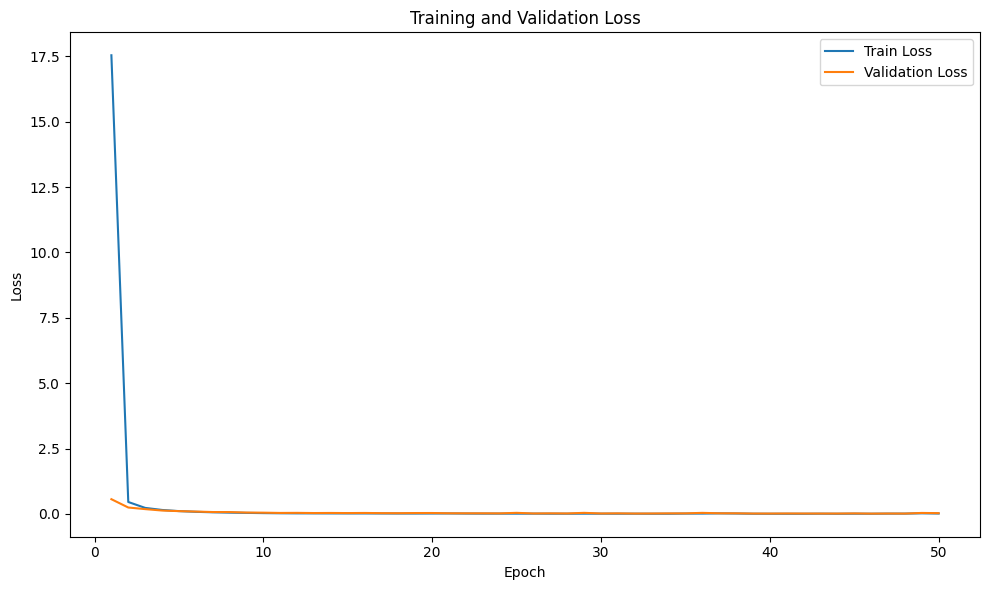

Test Loss: 0.0077


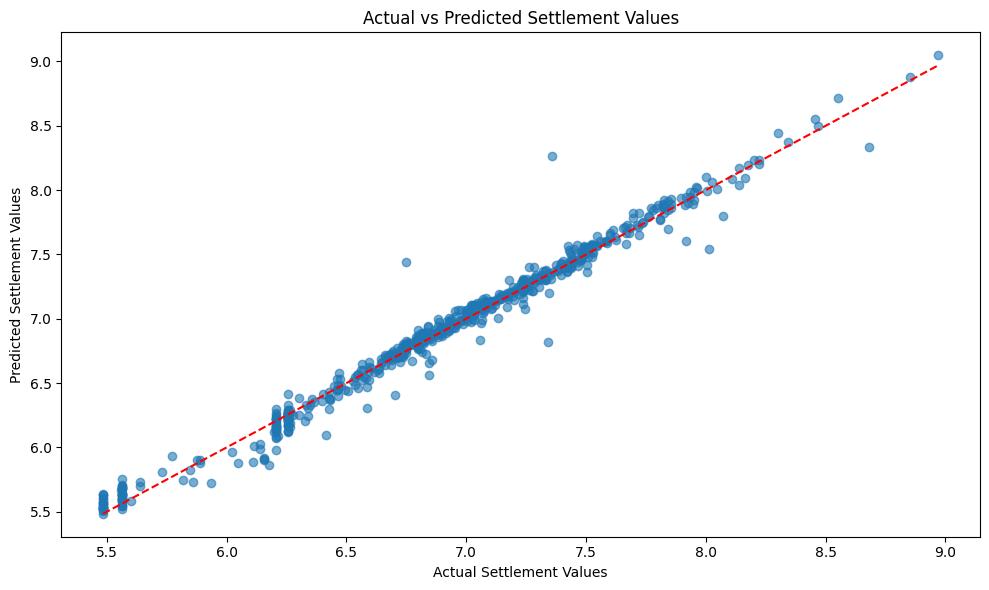

In [13]:
# Check if MPS (Metal Performance Shaders) backend is available for Apple Silicon
device = torch.device("mps")
print(f"Using device: {device}")

# Define the PyTorch neural network model
class InsuranceNN(nn.Module):
    def __init__(self, input_size):
        super(InsuranceNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),  # Input layer to first hidden layer
            nn.ReLU(),                 # Activation function
            nn.Linear(64, 32),         # First hidden layer to second hidden layer
            nn.ReLU(),                 # Activation function
            nn.Linear(32, 1)           # Second hidden layer to output layer
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model
input_size = X_train.shape[1]
model = InsuranceNN(input_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
predictions_list = []
actuals_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.size(0)

        predictions_list.extend(predictions.cpu().numpy())
        actuals_list.extend(y_batch.cpu().numpy())

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actuals_list, predictions_list, alpha=0.6)
plt.plot([min(actuals_list), max(actuals_list)], [min(actuals_list), max(actuals_list)], 'r--')
plt.xlabel("Actual Settlement Values")
plt.ylabel("Predicted Settlement Values")
plt.title("Actual vs Predicted Settlement Values")
plt.tight_layout()
plt.show()

# Train and Evaluate the Model
Train the neural network model using the training data. Implement early stopping based on validation performance. Evaluate the model on the test set and visualize the results.

Epoch 1/50, Train Loss: 0.0065, Val Loss: 0.0124
Epoch 2/50, Train Loss: 0.0068, Val Loss: 0.0167
Epoch 3/50, Train Loss: 0.0069, Val Loss: 0.0140
Epoch 4/50, Train Loss: 0.0035, Val Loss: 0.0097
Epoch 5/50, Train Loss: 0.0035, Val Loss: 0.0121
Epoch 6/50, Train Loss: 0.0034, Val Loss: 0.0110
Epoch 7/50, Train Loss: 0.0069, Val Loss: 0.0190
Epoch 8/50, Train Loss: 0.0098, Val Loss: 0.0226
Epoch 9/50, Train Loss: 0.0100, Val Loss: 0.0175
Early stopping triggered.
Test Loss: 0.0055


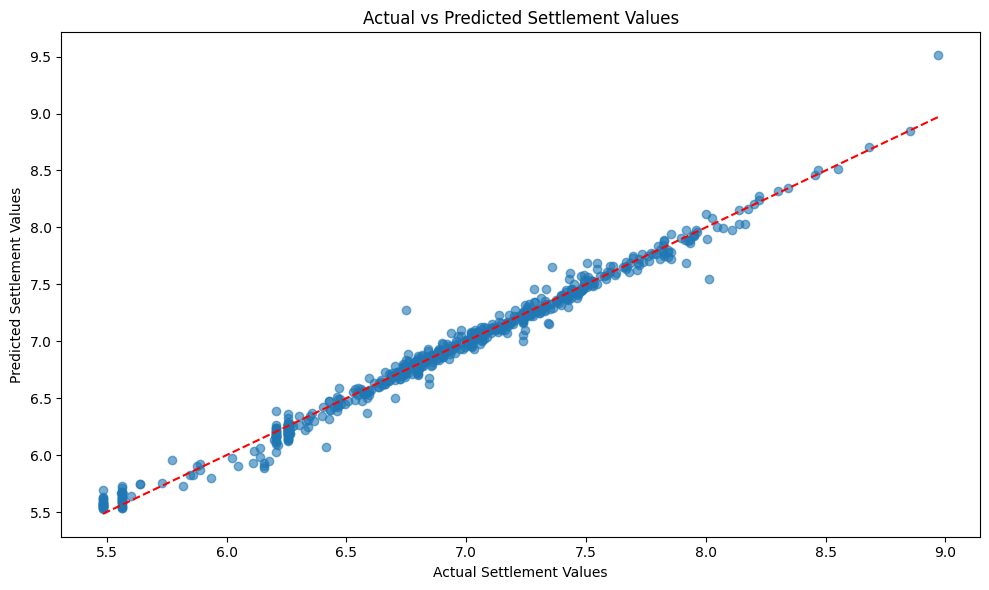

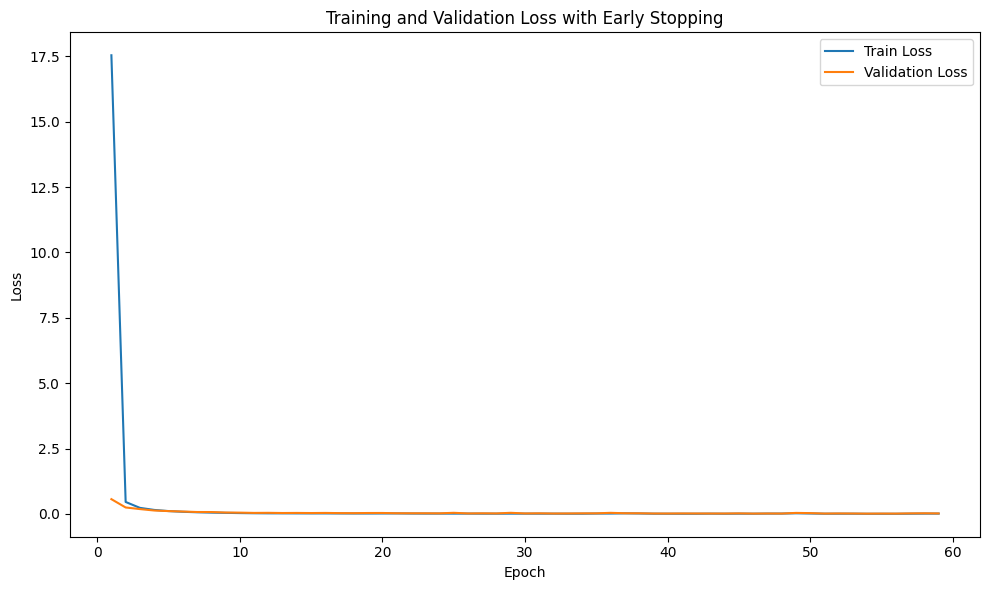

In [14]:
# Train and Evaluate the Model

# Implement early stopping
early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
predictions_list = []
actuals_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.size(0)

        predictions_list.extend(predictions.cpu().numpy())
        actuals_list.extend(y_batch.cpu().numpy())

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actuals_list, predictions_list, alpha=0.6)
plt.plot([min(actuals_list), max(actuals_list)], [min(actuals_list), max(actuals_list)], 'r--')
plt.xlabel("Actual Settlement Values")
plt.ylabel("Predicted Settlement Values")
plt.title("Actual vs Predicted Settlement Values")
plt.tight_layout()
plt.show()

# Visualize training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss with Early Stopping")
plt.legend()
plt.tight_layout()
plt.show()

Errors in GBP (£):
MSE: £58927.57
RMSE: £242.75
MAE: £61.82
MAPE: 4.94%


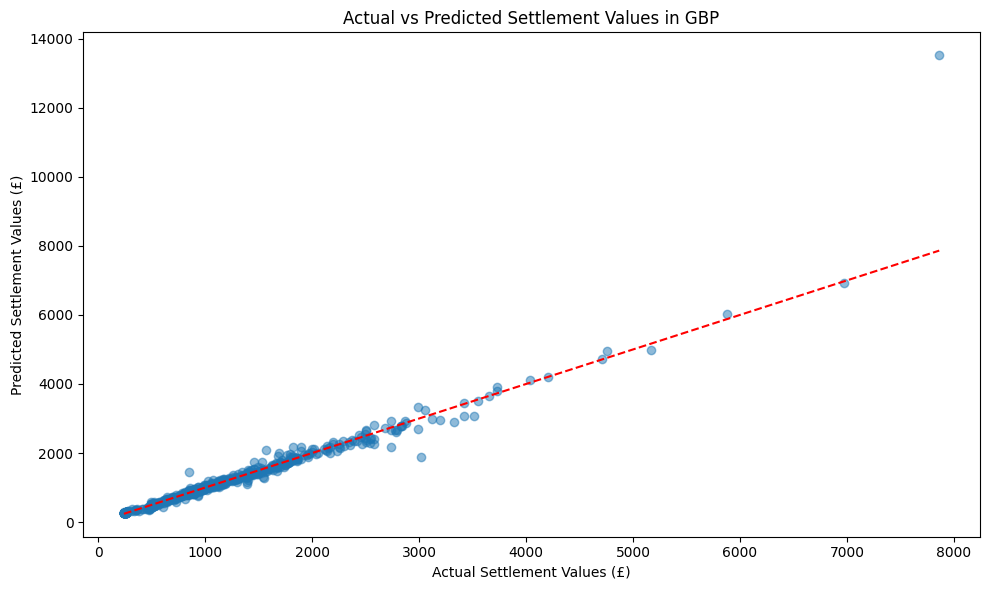

In [15]:
# Add this after model evaluation section
def evaluate_model_in_gbp(model, data_loader, device):
    """
    Evaluate the model and report errors in GBP (pounds)
    """
    model.eval()
    actual_gbp = []
    predicted_gbp = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Get predictions
            predictions = model(X_batch)
            
            y_gbp = torch.expm1(y_batch).cpu().numpy()
            pred_gbp = torch.expm1(predictions).cpu().numpy()
            
            actual_gbp.extend(y_gbp)
            predicted_gbp.extend(pred_gbp)
    
    # Calculate error metrics in GBP
    mse_gbp = mean_squared_error(actual_gbp, predicted_gbp)
    rmse_gbp = np.sqrt(mse_gbp)
    mae_gbp = mean_absolute_error(actual_gbp, predicted_gbp)
    mape_gbp = np.mean(np.abs((np.array(actual_gbp) - np.array(predicted_gbp)) / np.array(actual_gbp))) * 100
    
    print("Errors in GBP (£):")
    print(f"MSE: £{mse_gbp:.2f}")
    print(f"RMSE: £{rmse_gbp:.2f}")
    print(f"MAE: £{mae_gbp:.2f}")
    print(f"MAPE: {mape_gbp:.2f}%")
    
    return {
        'MSE_GBP': mse_gbp,
        'RMSE_GBP': rmse_gbp,
        'MAE_GBP': mae_gbp,
        'MAPE_GBP': mape_gbp,
        'actual_gbp': actual_gbp,
        'predicted_gbp': predicted_gbp
    }

# Call this function to evaluate on test set
gbp_metrics = evaluate_model_in_gbp(model, test_loader, device)

# Visualize predictions in GBP
plt.figure(figsize=(10, 6))
plt.scatter(gbp_metrics['actual_gbp'], gbp_metrics['predicted_gbp'], alpha=0.5)
plt.plot([min(gbp_metrics['actual_gbp']), max(gbp_metrics['actual_gbp'])], 
         [min(gbp_metrics['actual_gbp']), max(gbp_metrics['actual_gbp'])], 'r--')
plt.xlabel('Actual Settlement Values (£)')
plt.ylabel('Predicted Settlement Values (£)')
plt.title('Actual vs Predicted Settlement Values in GBP')
plt.tight_layout()
plt.show()

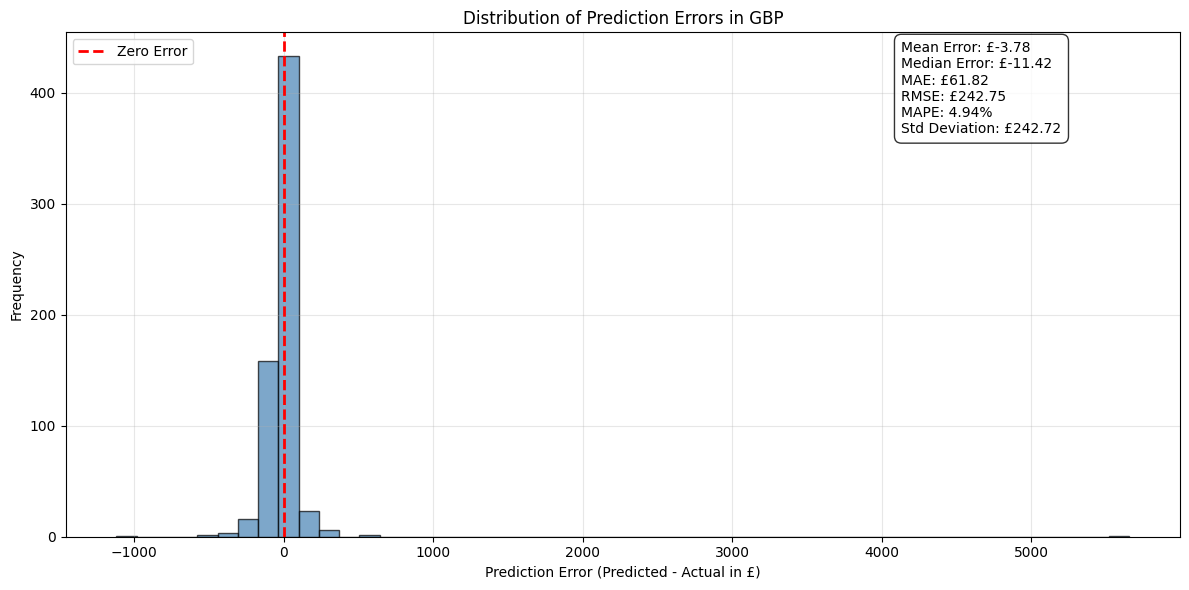

Error Analysis Complete!
Mean Absolute Error (MAE): £61.82
Root Mean Squared Error (RMSE): £242.75
Mean Absolute Percentage Error (MAPE): 4.94%


In [16]:
def analyze_prediction_errors_gbp(actual_gbp, predicted_gbp, figsize=(12, 6), bins=50, 
                                  color='steelblue', show_plot=True, save_path=None):
    """
    Analyze and visualize the errors between predicted and actual values in GBP (pounds).
    
    Parameters:
    -----------
    actual_gbp : array-like
        Actual settlement values in GBP
    predicted_gbp : array-like
        Predicted settlement values in GBP
    figsize : tuple, optional
        Figure size (width, height) in inches
    bins : int, optional
        Number of histogram bins
    color : str, optional
        Color for the histogram bars
    show_plot : bool, optional
        Whether to display the plot
    save_path : str, optional
        Path to save the figure (if None, figure is not saved)
        
    Returns:
    --------
    dict
        Dictionary containing error metrics (mean, median, std, MAE, RMSE)
    """
    # Convert inputs to numpy arrays if they aren't already
    actual_gbp = np.array(actual_gbp).flatten()
    predicted_gbp = np.array(predicted_gbp).flatten()
    
    # Calculate differences
    differences_gbp = predicted_gbp - actual_gbp
    
    # Calculate statistics
    mean_error = np.mean(differences_gbp)
    median_error = np.median(differences_gbp)
    std_error = np.std(differences_gbp)
    mae = np.mean(np.abs(differences_gbp))
    rmse = np.sqrt(np.mean(np.square(differences_gbp)))
    mape = np.mean(np.abs(differences_gbp / actual_gbp)) * 100
    
    # Create a histogram of the differences
    plt.figure(figsize=figsize)
    plt.hist(differences_gbp, bins=bins, alpha=0.7, color=color, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    
    # Add labels and title
    plt.xlabel('Prediction Error (Predicted - Actual in £)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors in GBP')
    
    # Add statistics to the plot
    stats_text = (f'Mean Error: £{mean_error:.2f}\n'
                  f'Median Error: £{median_error:.2f}\n'
                  f'MAE: £{mae:.2f}\n'
                  f'RMSE: £{rmse:.2f}\n'
                  f'MAPE: {mape:.2f}%\n'
                  f'Std Deviation: £{std_error:.2f}')
    
    plt.annotate(stats_text, xy=(0.75, 0.8), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
    
    plt.legend()
    plt.tight_layout()
    plt.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    # Return error metrics as a dictionary
    return {
        'mean_error': mean_error,
        'median_error': median_error,
        'std_error': std_error,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

# Example usage - add this after evaluating your model with the evaluate_model_in_gbp function
error_metrics = analyze_prediction_errors_gbp(
    gbp_metrics['actual_gbp'], 
    gbp_metrics['predicted_gbp']
)

print("Error Analysis Complete!")
print(f"Mean Absolute Error (MAE): £{error_metrics['mae']:.2f}")
print(f"Root Mean Squared Error (RMSE): £{error_metrics['rmse']:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {error_metrics['mape']:.2f}%")

# Compare with Other Models



Model Performance Comparison:
               Model       MSE       R^2
0     Neural Network  0.005547  0.986814
1  Linear Regression  0.050403  0.880183
2   Ridge Regression  0.050353  0.880301
3      Random Forest  0.000018  0.999957


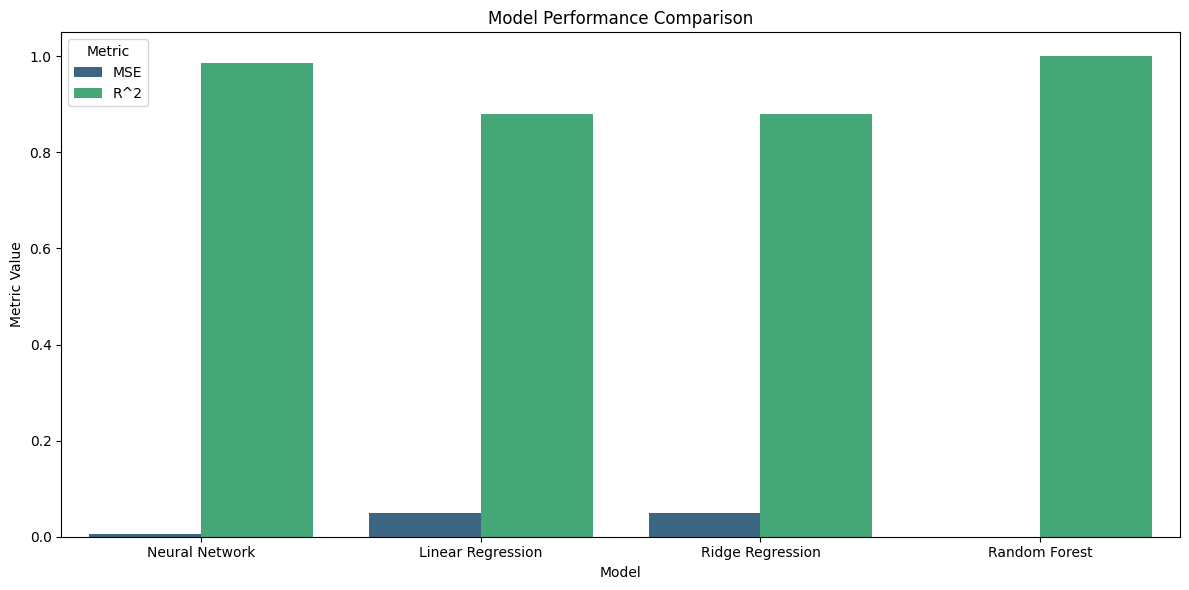

In [17]:
# Compare the neural network model with other models

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

# Define and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
lr_predictions = lr_model.predict(X_test.cpu().numpy())
lr_mse = mean_squared_error(y_test.cpu().numpy(), lr_predictions)
lr_r2 = r2_score(y_test.cpu().numpy(), lr_predictions)

# Define and train Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
ridge_predictions = ridge_model.predict(X_test.cpu().numpy())
ridge_mse = mean_squared_error(y_test.cpu().numpy(), ridge_predictions)
ridge_r2 = r2_score(y_test.cpu().numpy(), ridge_predictions)

# Define and train Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train.cpu().numpy(), y_train.cpu().numpy().ravel())
rf_predictions = rf_model.predict(X_test.cpu().numpy())
rf_mse = mean_squared_error(y_test.cpu().numpy(), rf_predictions)
rf_r2 = r2_score(y_test.cpu().numpy(), rf_predictions)

# Compare performance metrics
models_comparison = pd.DataFrame({
    'Model': ['Neural Network', 'Linear Regression', 'Ridge Regression', 'Random Forest'],
    'MSE': [test_loss, lr_mse, ridge_mse, rf_mse],
    'R^2': [r2_score(y_test.cpu().numpy(), np.array(predictions_list).flatten()), lr_r2, ridge_r2, rf_r2]
})

print("\nModel Performance Comparison:")
print(models_comparison)

# Visualize the performance metrics
plt.figure(figsize=(12, 6))
sns.barplot(data=models_comparison.melt(id_vars='Model', var_name='Metric', value_name='Value'),
            x='Model', y='Value', hue='Metric', palette='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

# Implement Simple NLP for Accident Descriptions
Implement a basic text processing pipeline for the accident descriptions. Use TF-IDF or simple embeddings to convert text to numerical features. Incorporate these features into the model.

In [18]:
# Implement Simple NLP for Accident Descriptions

from sklearn.feature_extraction.text import TfidfVectorizer

# Check if 'AccidentDescription' column exists
if 'AccidentDescription' in claim_data.columns:
    # Extract accident descriptions
    accident_descriptions = claim_data['AccidentDescription'].fillna('')  # Replace NaN with empty strings

    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limit to top 100 features for simplicity

    # Fit and transform the accident descriptions
    tfidf_features = tfidf_vectorizer.fit_transform(accident_descriptions).toarray()

    # Convert to DataFrame for easier handling
    tfidf_df = pd.DataFrame(tfidf_features, columns=[f"TFIDF_{i}" for i in range(tfidf_features.shape[1])])

    # Add TF-IDF features to the original dataset
    claim_data = pd.concat([claim_data.reset_index(drop=True), tfidf_df], axis=1)

    print("TF-IDF features added to the dataset.")
else:
    print("Column 'AccidentDescription' not found in the dataset.")

# Update the feature set to include TF-IDF features
tfidf_cols = [col for col in claim_data.columns if col.startswith("TFIDF_")]
X = preprocessor.fit_transform(claim_data.drop(columns=[target_col] + tfidf_cols))
X_tfidf = claim_data[tfidf_cols].values

# Combine numerical, categorical, and TF-IDF features
X_combined = np.hstack((X, X_tfidf))

# Standardize the combined features
X_combined[:, :len(numerical_cols)] = scaler.fit_transform(X_combined[:, :len(numerical_cols)])

# Convert to PyTorch tensors
X_tensor_combined = torch.tensor(X_combined, dtype=torch.float32)

# Split the data into training, validation, and test sets
X_train_combined, X_temp_combined, y_train, y_temp = train_test_split(X_tensor_combined, y_tensor, test_size=0.3, random_state=42)
X_val_combined, X_test_combined, y_val, y_test = train_test_split(X_temp_combined, y_temp, test_size=0.5, random_state=42)

# Create DataLoader objects for PyTorch
train_dataset_combined = TensorDataset(X_train_combined, y_train)
val_dataset_combined = TensorDataset(X_val_combined, y_val)
test_dataset_combined = TensorDataset(X_test_combined, y_test)

train_loader_combined = DataLoader(train_dataset_combined, batch_size=batch_size, shuffle=True)
val_loader_combined = DataLoader(val_dataset_combined, batch_size=batch_size, shuffle=False)
test_loader_combined = DataLoader(test_dataset_combined, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Training set size with TF-IDF: {len(train_dataset_combined)} samples")
print(f"Validation set size with TF-IDF: {len(val_dataset_combined)} samples")
print(f"Test set size with TF-IDF: {len(test_dataset_combined)} samples")

TF-IDF features added to the dataset.
Training set size with TF-IDF: 3007 samples
Validation set size with TF-IDF: 645 samples
Test set size with TF-IDF: 645 samples
